# TRANSFER LEARNING



In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [ ]:
batch_size = 1024
valid_size=0.1
seed = 121

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes, act_func):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(64),act_func)
        self.layer2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(64),act_func, nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(128),act_func)
        self.layer4 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(128),act_func,nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(256),act_func)
        self.layer6 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(256),act_func)
        self.layer7 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(256),act_func,nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(512),act_func)
        self.layer9 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(512),act_func)
        self.layer10 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(512),act_func,nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(512),act_func)
        self.layer12 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(512),act_func)
        self.layer13 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),nn.BatchNorm2d(512),act_func,nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(512, 4096),act_func)
        self.fc1 = nn.Sequential(nn.Dropout(0.5),nn.Linear(4096, 4096),act_func)
        self.fc2= nn.Sequential(nn.Linear(4096, num_classes),nn.Softmax())
  

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.Resize(48),transforms.Grayscale(3),transforms.ToTensor()]))
test_set = datasets.MNIST(root='./data', train=False,transform=transforms.Compose([transforms.Resize(48),transforms.Grayscale(3),transforms.ToTensor()]))
valid_set = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.Resize(48),transforms.Grayscale(3),transforms.ToTensor()]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



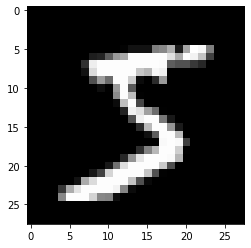

Target = 5


In [ ]:
plt.imshow(train_set.data[0], cmap='gray')
plt.show()
print("Target = %i" % train_set.targets[0])

In [ ]:
test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

num_train = len(train_set)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.seed(seed)
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(valid_set, batch_size=batch_size, sampler=valid_sampler)

In [ ]:


def train(num_epochs, cnn,train_loader,test_loader):
    epochs = []

    losses = []
    accs = []

    val_losses = []
    val_accs = []
    # Train the model
    total_step = len(train_loader)

    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            
            # gives batch data, normalize x when iterate train_loader
           
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)


            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 10 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
  
        correct_val = 0
        total_val = 0
        correct = 0
        total = 0
        total_loss = 0
        total_val_loss = 0

        with torch.no_grad():
            for images, labels in train_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        print()
        print('Epoch [{}/{}]\n Train Loss: {:.4f}, Train Accuracy: {:.4f}\n Val Loss: {:.4f}, Val Accuracy: {:.4f}' .format(epoch + 1, num_epochs, total_loss, correct/total, total_val_loss, correct_val/total_val ))
        print()
        epochs += [epoch+1]
        losses += [total_loss]
        accs += [correct/total]
        val_losses += [total_val_loss]
        val_accs += [correct_val/total_val]
            
            
    
    
    return (epochs,losses,accs,val_losses,val_accs)


In [ ]:
num_classes = 10
num_epochs = 5
learning_rate = 5*1e-5
act_func = nn.ReLU()
criterion = nn.CrossEntropyLoss()

model = VGG16(num_classes, act_func).to(device)

In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

In [ ]:
epochs,losses,accs,val_losses,val_accs = train(num_epochs,model,train_loader,test_loader)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [1/5], Step [10/53], Loss: 2.1561
Epoch [1/5], Step [20/53], Loss: 2.2805
Epoch [1/5], Step [30/53], Loss: 1.9233
Epoch [1/5], Step [40/53], Loss: 1.6884
Epoch [1/5], Step [50/53], Loss: 1.5533

Epoch [1/5]
 Train Loss: 83.6073, Train Accuracy: 0.8868
 Val Loss: 9.4745, Val Accuracy: 0.8868

Epoch [2/5], Step [10/53], Loss: 1.4785
Epoch [2/5], Step [20/53], Loss: 1.4932
Epoch [2/5], Step [30/53], Loss: 1.4880
Epoch [2/5], Step [40/53], Loss: 1.4869
Epoch [2/5], Step [50/53], Loss: 1.4832

Epoch [2/5]
 Train Loss: 78.2780, Train Accuracy: 0.9856
 Val Loss: 8.8705, Val Accuracy: 0.9842

Epoch [3/5], Step [10/53], Loss: 1.4698
Epoch [3/5], Step [20/53], Loss: 1.4725
Epoch [3/5], Step [30/53], Loss: 1.4714
Epoch [3/5], Step [40/53], Loss: 1.4695
Epoch [3/5], Step [50/53], Loss: 1.4735

Epoch [3/5]
 Train Loss: 78.2182, Train Accuracy: 0.9858
 Val Loss: 8.8748, Val Accuracy: 0.9825

Epoch [4/5], Step [10/53], Loss: 1.4689
Epoch [4/5], Step [20/53], Loss: 1.4708
Epoch [4/5], Step [30/5

In [ ]:
label_to_class = {0:0, 2:0, 3:0, 5:0, 6:0, 8:0, 9:0, 1:1, 4:1, 7:1}

In [ ]:
new_train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.Resize(48),transforms.Grayscale(3),transforms.ToTensor()]))
new_test_set = datasets.MNIST(root='./data', train=False,transform=transforms.Compose([transforms.Resize(48),transforms.Grayscale(3),transforms.ToTensor()]))
new_valid_set = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.Resize(48),transforms.Grayscale(3),transforms.ToTensor()]))

In [ ]:
for i in range(len(new_train_set)):
  new_train_set.targets[i] = torch.tensor(label_to_class[int(new_train_set.targets[i])])

for i in range(len(new_test_set)):
  new_test_set.targets[i] = torch.tensor(label_to_class[int(new_test_set.targets[i])])

for i in range(len(new_valid_set)):
  new_valid_set.targets[i] = torch.tensor(label_to_class[int(new_valid_set.targets[i])])

In [ ]:
test_loader = DataLoader(new_test_set, batch_size=batch_size,shuffle=True)

num_train = len(new_train_set)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.seed(seed)
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(new_train_set, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(new_valid_set, batch_size=batch_size, sampler=valid_sampler)

In [ ]:
for param in model.parameters():
  param.required_grad = False

fc_input_size = 4096
model.fc2 = nn.Sequential(nn.Linear(fc_input_size, 2), nn.Sigmoid()).to(device)

In [ ]:
for param in model.fc2.parameters():
  param.requires_grad = True

In [ ]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

In [ ]:
epochs,losses,accs,val_losses,val_accs = train(50,model,train_loader,test_loader)

Epoch [1/50], Step [10/53], Loss: 0.4542
Epoch [1/50], Step [20/53], Loss: 0.3259
Epoch [1/50], Step [30/53], Loss: 0.3204
Epoch [1/50], Step [40/53], Loss: 0.3231
Epoch [1/50], Step [50/53], Loss: 0.3181

Epoch [1/50]
 Train Loss: 16.9440, Train Accuracy: 0.9935
 Val Loss: 1.9164, Val Accuracy: 0.9937

Epoch [2/50], Step [10/53], Loss: 0.3178
Epoch [2/50], Step [20/53], Loss: 0.3201
Epoch [2/50], Step [30/53], Loss: 0.3155
Epoch [2/50], Step [40/53], Loss: 0.3183
Epoch [2/50], Step [50/53], Loss: 0.3157

Epoch [2/50]
 Train Loss: 16.7860, Train Accuracy: 0.9965
 Val Loss: 1.8980, Val Accuracy: 0.9967

Epoch [3/50], Step [10/53], Loss: 0.3162
Epoch [3/50], Step [20/53], Loss: 0.3145
Epoch [3/50], Step [30/53], Loss: 0.3155
Epoch [3/50], Step [40/53], Loss: 0.3171
Epoch [3/50], Step [50/53], Loss: 0.3139

Epoch [3/50]
 Train Loss: 16.7159, Train Accuracy: 0.9979
 Val Loss: 1.8955, Val Accuracy: 0.9972

Epoch [4/50], Step [10/53], Loss: 0.3167
Epoch [4/50], Step [20/53], Loss: 0.3175
Epo

In [ ]:
print(losses)
print()
print(accs)
print()
print(val_losses)
print()
print(val_accs)

[16.943966180086136, 16.786026298999786, 16.715864181518555, 16.69388124346733, 16.709775537252426, 16.769391030073166, 16.67539843916893, 16.682978481054306, 16.68420159816742, 16.655346274375916, 16.662237465381622, 16.78737834095955, 16.702432930469513, 16.67975103855133, 16.715912997722626, 16.676700085401535, 16.67516201734543, 16.645279973745346, 16.636960685253143, 16.63563597202301, 16.704100281000137, 16.62863513827324, 16.657619059085846, 16.724348038434982, 16.663997381925583, 16.648925215005875, 16.65681102871895, 16.632926136255264, 16.664057284593582, 16.64239338040352, 16.634458303451538, 16.641243368387222, 16.630357205867767, 16.866125464439392, 16.653152734041214, 16.673747658729553, 16.681360870599747, 16.692727267742157, 16.63985139131546, 16.626843839883804, 16.62534847855568, 16.631366223096848, 16.623954743146896, 16.70641353726387, 16.715559244155884, 16.628893464803696, 16.643903702497482, 16.66258591413498, 16.631207525730133, 16.652126014232635]

[0.993462962

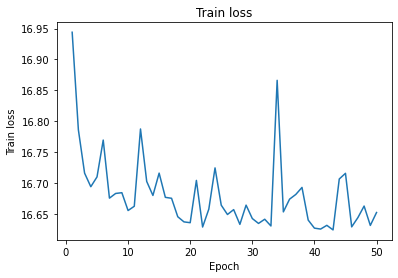

In [ ]:
plt.plot(np.array(epochs), np.array(losses))
plt.xlabel("Epoch") 
plt.ylabel("Train loss")
plt.title("Train loss")
plt.show()

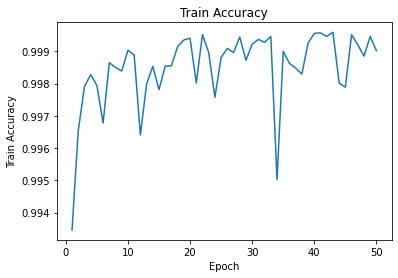

In [ ]:
plt.plot(np.array(epochs), np.array(accs))
plt.xlabel("Epoch") 
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy")
plt.show()

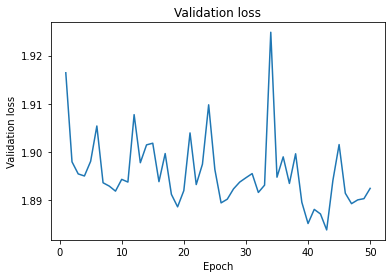

In [ ]:
plt.plot(np.array(epochs), np.array(val_losses))
plt.xlabel("Epoch") 
plt.ylabel("Validation loss")
plt.title("Validation loss")
plt.show()

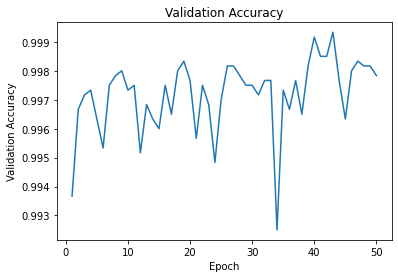

In [ ]:
plt.plot(np.array(epochs), np.array(val_accs))
plt.xlabel("Epoch") 
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy")
plt.show()

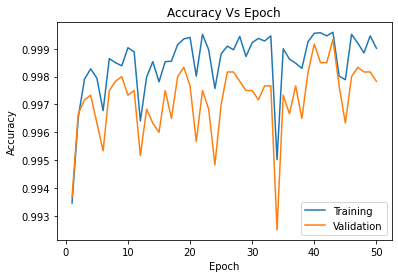

In [ ]:
plt.plot(np.array(epochs),np.array(accs),label = 'Training')
plt.plot(np.array(epochs),np.array(val_accs),label = 'Validation')
plt.xlabel("Epoch") 
plt.ylabel("Accuracy")
plt.title("Accuracy Vs Epoch")
plt.legend()
plt.show()

In [ ]:
total_loss = 0
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Test Loss: {:.4f}, Test Accuracy: {:.4f}' .format(total_loss, correct/total))

Test Loss: 3.1774, Test Accuracy: 0.9953
